In [10]:
from FVG import FVGStrategy

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import tqdm

from helpers import *


import warnings
warnings.filterwarnings("ignore")


import_search = True

# get best params
results = pd.read_csv('/Users/hatim/Desktop/Applied Forecasting/Final Project/Algo Trading/FVG_Grid_Search/results.csv')
results.sort_values(by='Strategy Sharpe Ratio', ascending=False, inplace=True)
derived_params = results.iloc[0, :4]

In [44]:
def run_simulation(asset, param_selector = 'Strategy Sharpe Ratio'):
    df = pd.read_csv(f'/Users/hatim/Desktop/Applied Forecasting/Final Project/Algo Trading/Data/{asset.upper()}.csv')
    df.dropna(inplace=True)
    df.reset_index(inplace=True)

    # both key dataframes initialised
    rf = df['Risk Free Rate']
    df = df.drop(columns=['Risk Free Rate'])

    # get params
    if type(param_selector) == str:
        params = pd.read_csv(f'/Users/hatim/Desktop/Applied Forecasting/Final Project/Algo Trading/FVG_Grid_Search/{asset.lower()}_results.csv')
        params = params.sort_values(by=param_selector, ascending=False).iloc[0, :4]
    else:
        params = param_selector

    # get signals
    strategy = FVGStrategy(*params)
    signals_df = strategy.generate_signals(df)

    # add risk free rate
    signals_df['Risk Free Rate'] = (1 + rf) ** (1/365) - 1

    # simulate
    result = simmulate(signals_df, max_drawdown_threshold=0.4, drawdown_buffer=0.05)

    # print params and ASSET
    print(f'Params: {params}')
    print(f'Asset: {asset}')

    # plot results
    plot_portfolio_with_signals(result)
    plot_drawdown(result)
    plot_protection_mode(result)

    # generate report
    generate_report(result, verbose=True)
    
    

# ETH

Detecting Break Signals: 100%|██████████| 1946/1946 [00:00<00:00, 99183.60it/s]


Signal Generation Complete
Params: lookback_period    50.0
body_multiplier     1.5
backcandles        30.0
test_candles       10.0
Name: 0, dtype: float64
Asset: ETH


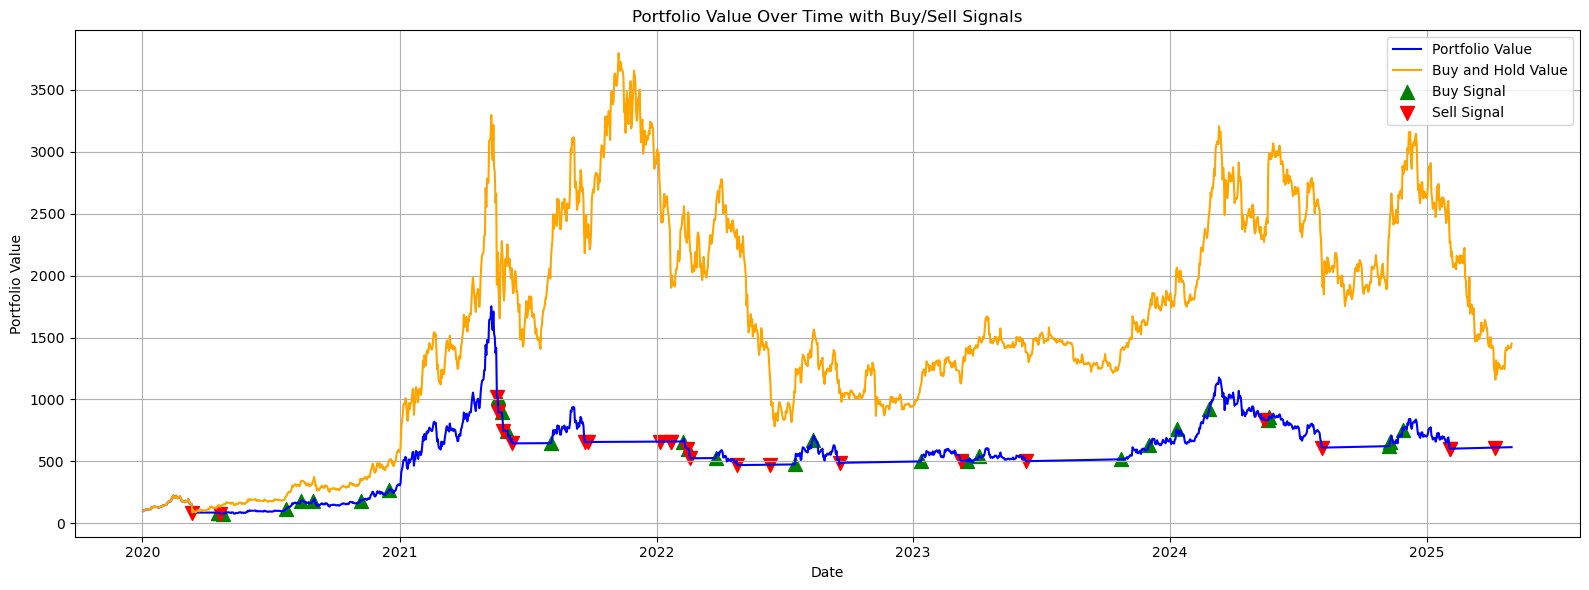

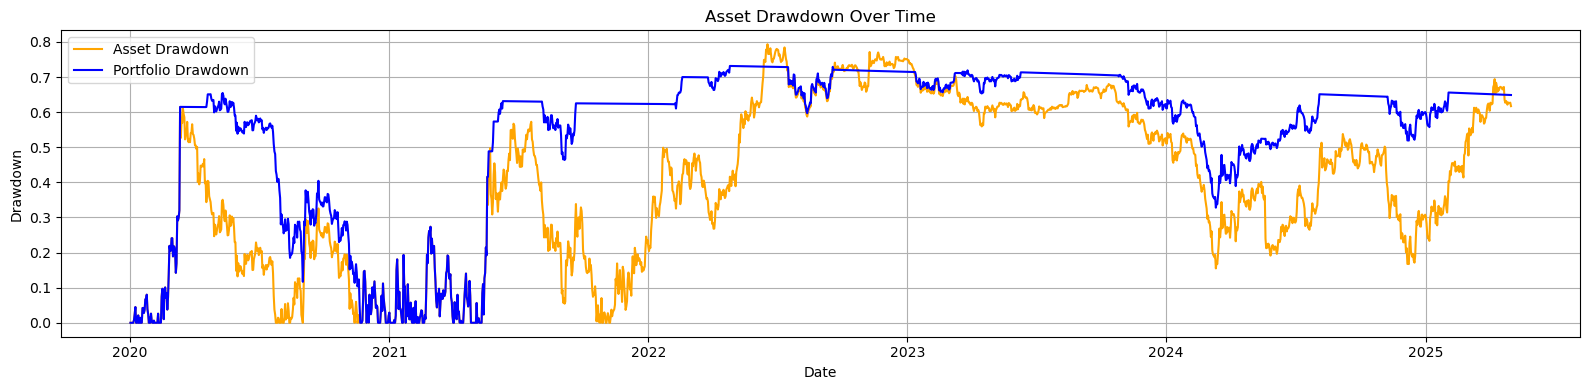

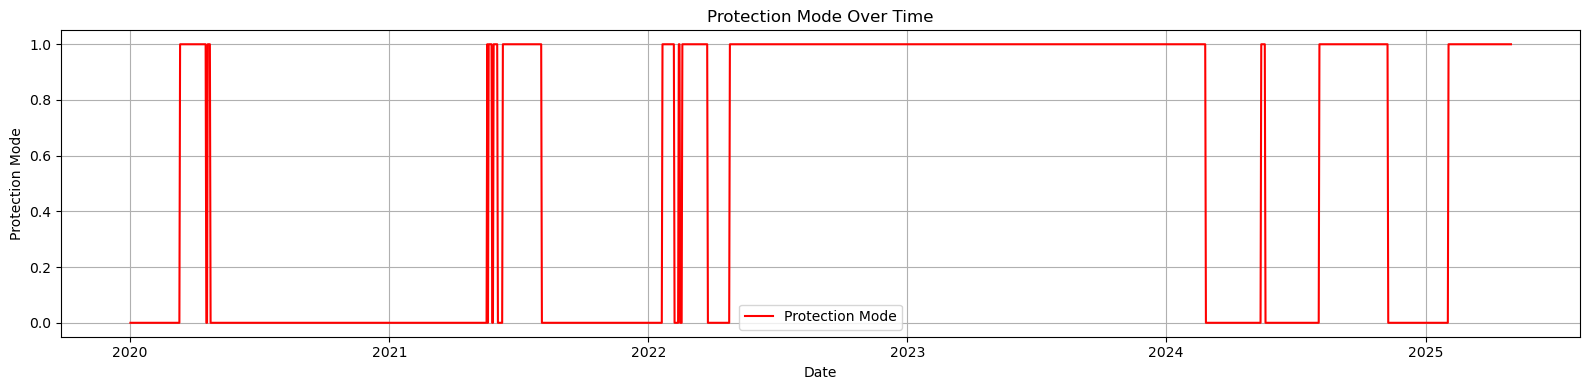

REPORT
--------------------------------
Date Range: 2020-01-02 00:00:00 - 2025-05-01 00:00:00
--------------------------------
Strategy Total Return: 44.63%
Buy and Hold Total Return: 67.26%
Strategy Improvement (%) : -33.65%
--------------------------------
Strategy Sharpe Ratio: 0.04
Buy and Hold Sharpe Ratio: 0.05
Strategy Improvement (%) : -17.19%
--------------------------------
Strategy Max Drawdown: 73.17%
Buy and Hold Max Drawdown: 79.35%
Strategy Improvement (%) : -7.79%
--------------------------------
# Buy Signals: 29
# Sell Signals: 23
# Hold Signals: 1895
--------------------------------
Average Gap : -1033.76 (-58.06%)
Standard Deviation of Gap : 700.72 (16.27%)


In [13]:
# run_simulation('ETH', param_selector='Strategy Sharpe Ratio')
run_simulation('ETH', derived_params)

# SOL

Detecting Break Signals: 100%|██████████| 849/849 [00:00<00:00, 116634.37it/s]


Signal Generation Complete
Params: lookback_period    50.0
body_multiplier     2.0
backcandles        60.0
test_candles       10.0
Name: 0, dtype: float64
Asset: SOL


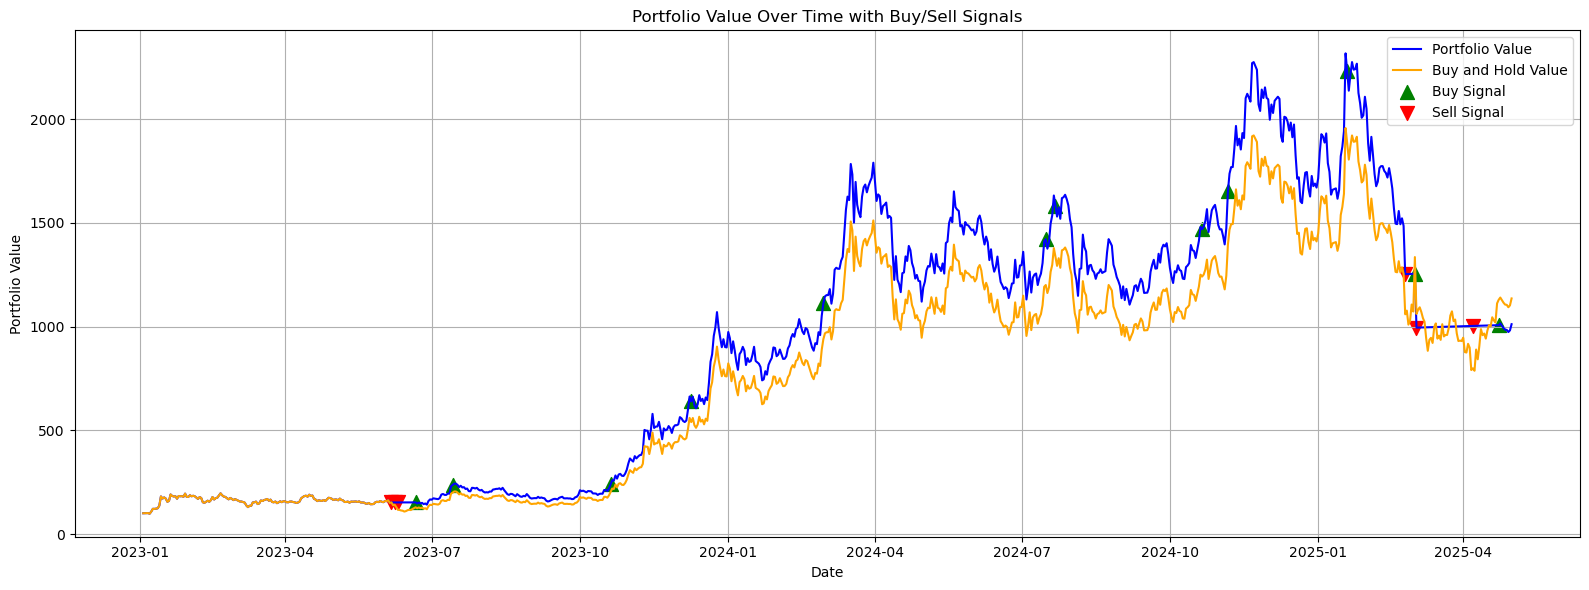

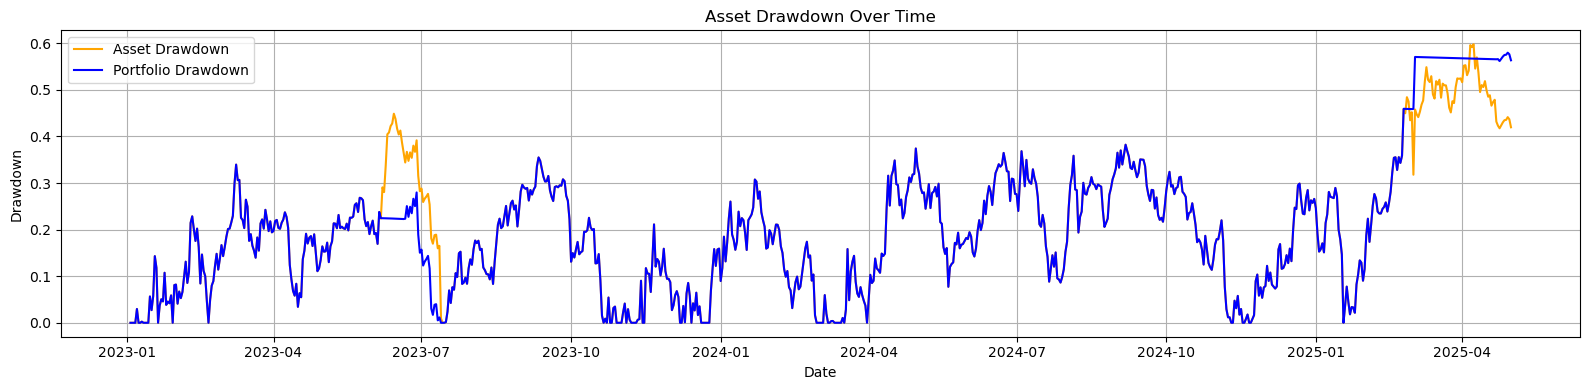

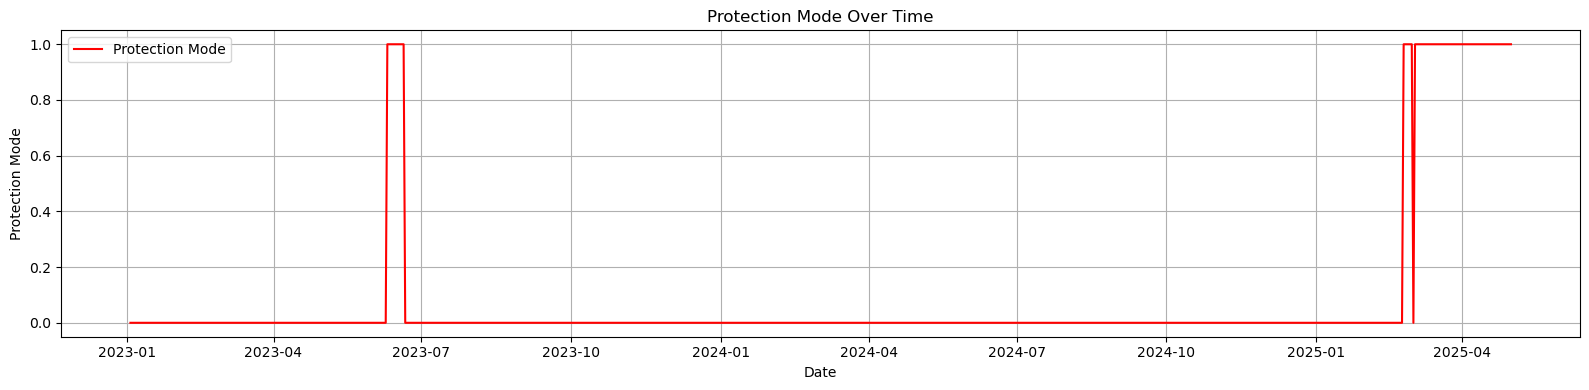

REPORT
--------------------------------
Date Range: 2023-01-03 00:00:00 - 2025-05-01 00:00:00
--------------------------------
Strategy Total Return: 181.59%
Buy and Hold Total Return: 194.70%
Strategy Improvement (%) : -6.73%
--------------------------------
Strategy Sharpe Ratio: 0.08
Buy and Hold Sharpe Ratio: 0.08
Strategy Improvement (%) : -1.08%
--------------------------------
Strategy Max Drawdown: 57.98%
Buy and Hold Max Drawdown: 59.79%
Strategy Improvement (%) : -3.02%
--------------------------------
# Buy Signals: 12
# Sell Signals: 6
# Hold Signals: 832
--------------------------------
Average Gap : 124.31 (14.02%)
Standard Deviation of Gap : 111.02 (8.48%)


In [45]:
run_simulation('SOL', param_selector='Strategy Sharpe Ratio')


# run_simulation('SOL', derived_params)



# XRP

Detecting Break Signals: 100%|██████████| 383/383 [00:00<00:00, 104076.35it/s]


Signal Generation Complete
Params: lookback_period    50.0
body_multiplier     1.5
backcandles        30.0
test_candles       10.0
Name: 0, dtype: float64
Asset: XRP


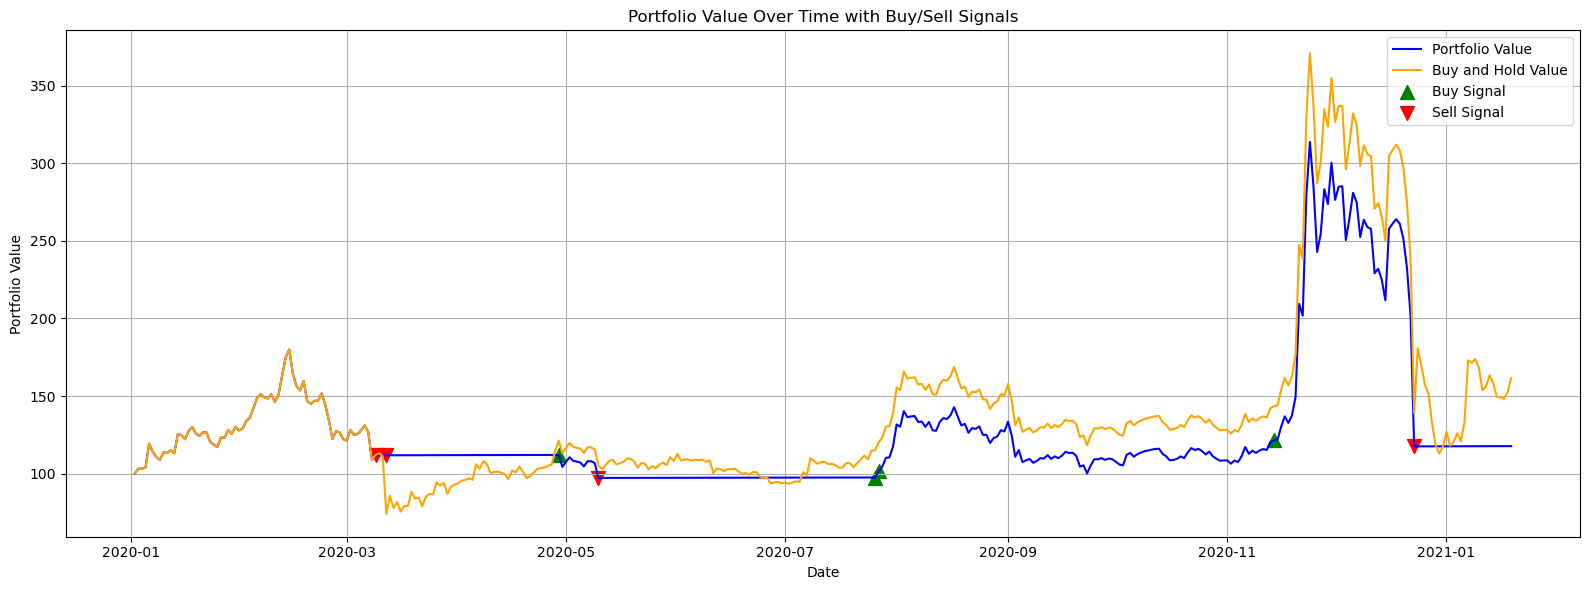

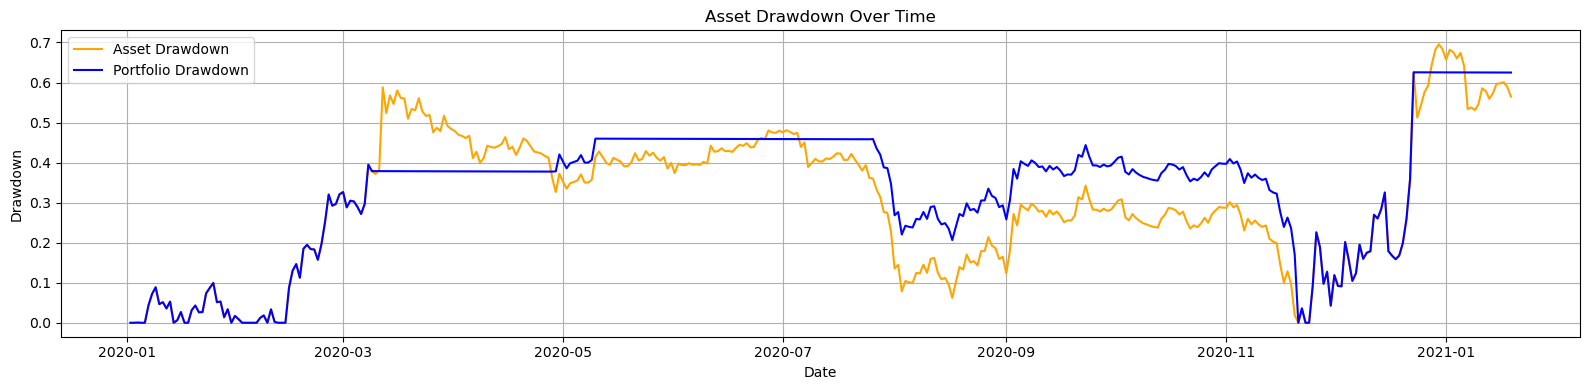

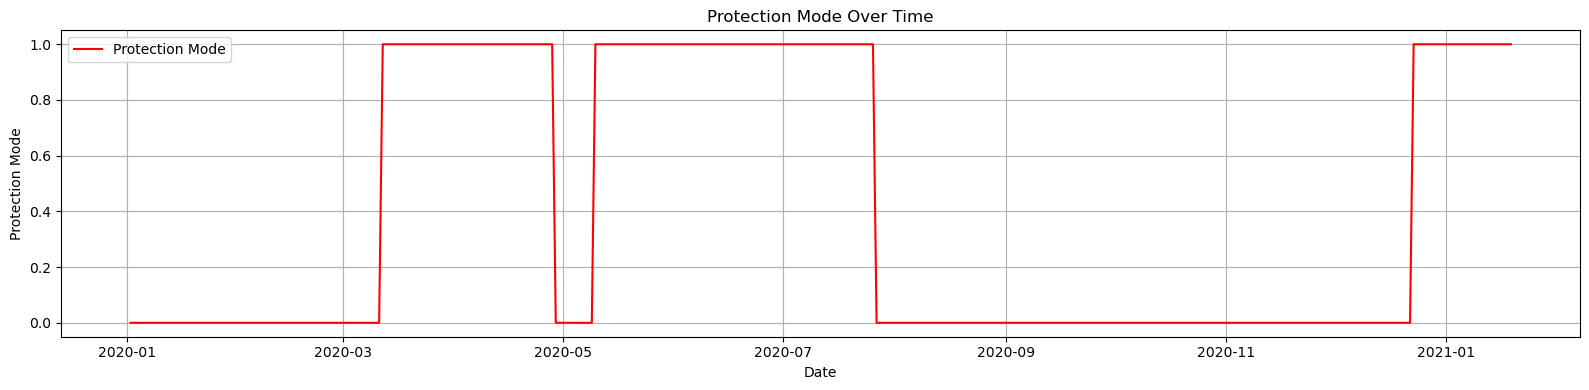

REPORT
--------------------------------
Date Range: 2020-01-02 00:00:00 - 2021-01-19 00:00:00
--------------------------------
Strategy Total Return: 109.88%
Buy and Hold Total Return: 149.94%
Strategy Improvement (%) : -26.71%
--------------------------------
Strategy Sharpe Ratio: 0.03
Buy and Hold Sharpe Ratio: 0.05
Strategy Improvement (%) : -34.95%
--------------------------------
Strategy Max Drawdown: 62.55%
Buy and Hold Max Drawdown: 69.55%
Strategy Improvement (%) : -10.07%
--------------------------------
# Buy Signals: 4
# Sell Signals: 4
# Hold Signals: 376
--------------------------------
Average Gap : -12.06 (-6.38%)
Standard Deviation of Gap : 18.41 (13.02%)


In [15]:
# run_simulation('XRP', param_selector='Strategy Sharpe Ratio')
run_simulation('XRP', derived_params)


# DOGE

Detecting Break Signals: 100%|██████████| 1214/1214 [00:00<00:00, 131767.33it/s]


Signal Generation Complete
Params: lookback_period    50.0
body_multiplier     1.5
backcandles        30.0
test_candles       10.0
Name: 0, dtype: float64
Asset: DOGE


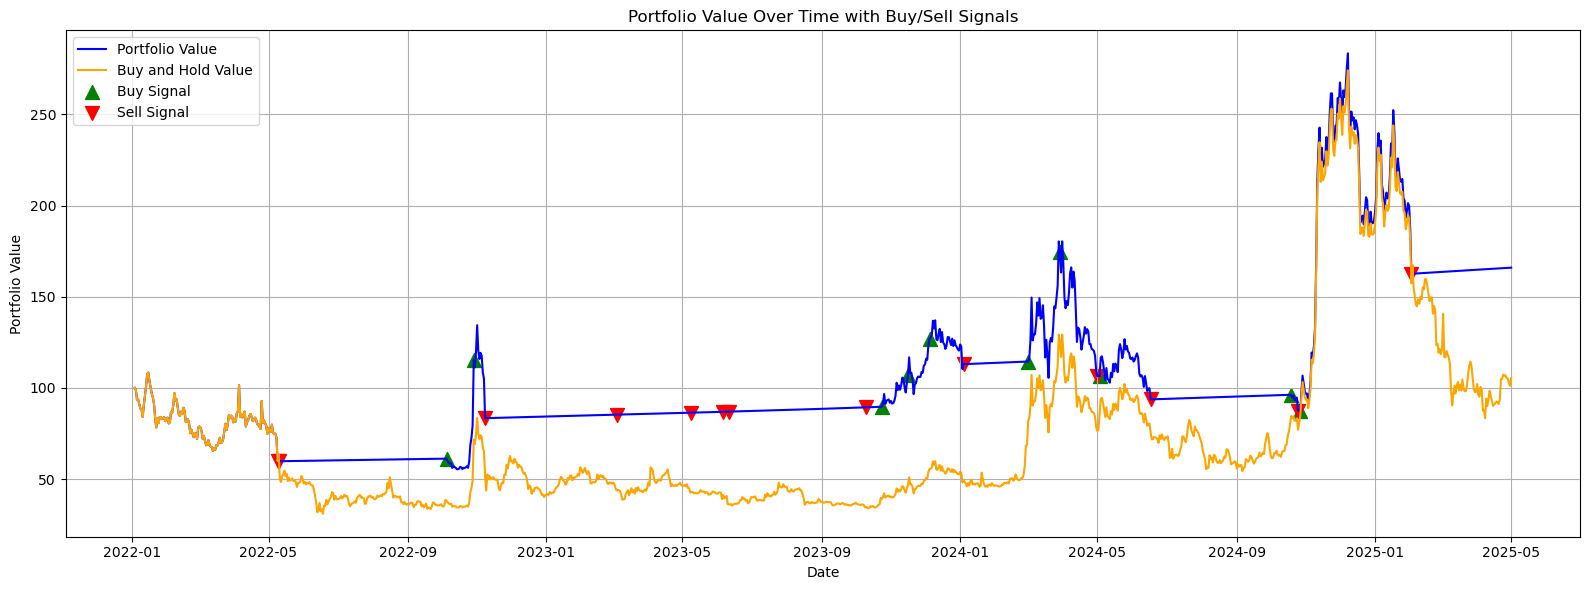

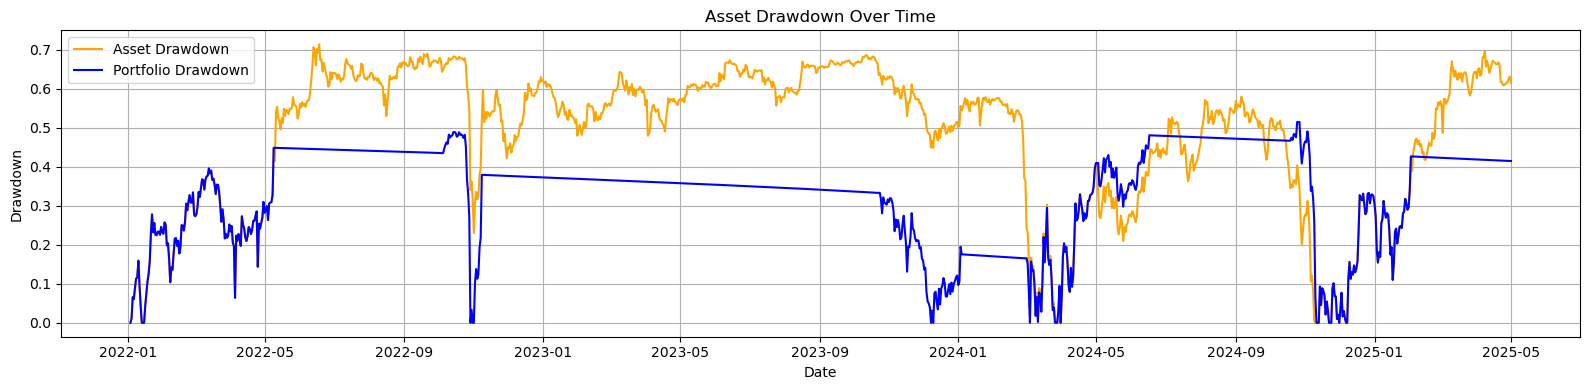

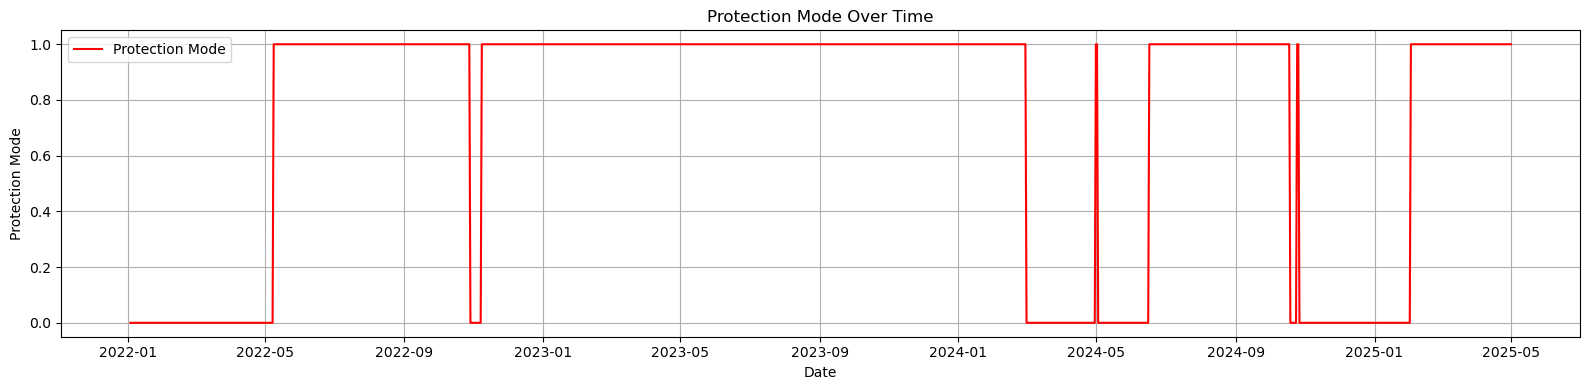

REPORT
--------------------------------
Date Range: 2022-01-03 00:00:00 - 2025-05-01 00:00:00
--------------------------------
Strategy Total Return: 34.19%
Buy and Hold Total Return: 24.15%
Strategy Improvement (%) : 41.59%
--------------------------------
Strategy Sharpe Ratio: 0.03
Buy and Hold Sharpe Ratio: 0.02
Strategy Improvement (%) : 13.43%
--------------------------------
Strategy Max Drawdown: 51.49%
Buy and Hold Max Drawdown: 71.39%
Strategy Improvement (%) : -27.87%
--------------------------------
# Buy Signals: 10
# Sell Signals: 13
# Hold Signals: 1192
--------------------------------
Average Gap : 32.20 (62.27%)
Standard Deviation of Gap : 20.58 (46.62%)


In [16]:
# run_simulation('DOGE', param_selector='Strategy Sharpe Ratio')
run_simulation('DOGE', derived_params)

# Stock Correlations

In [34]:
# get all files in the Data folder
import os
files = os.listdir('/Users/hatim/Desktop/Applied Forecasting/Final Project/Algo Trading/Data')

# get the files that end with .csv
csv_files = [file for file in files if file.endswith('.csv')]



# initialise a dataframe and load each csv file into it. I only need the close column. rename the close column to the asset name and join on the date column
res = pd.DataFrame()
for file in csv_files:
    df = pd.read_csv(f'/Users/hatim/Desktop/Applied Forecasting/Final Project/Algo Trading/Data/{file}')
    df = df[['Date', 'Close']]
    df.rename(columns={'Close': file.split('.')[0]}, inplace=True)
    df.set_index('Date', inplace=True)
    if res.empty:
        res = df
    elif df.columns[0] == 'XRP':
        continue
    else:
        res = res.join(df)


display(res.isnull().sum())
res.dropna(inplace=True)

BTC        0
ETH     1095
SOL     2191
DOGE    1826
dtype: int64

In [36]:
res.corr()

,BTC,ETH,SOL,DOGE
BTC,1.000000,0.706283,0.938043,0.858574
ETH,0.706283,1.000000,0.840347,0.654627
SOL,0.938043,0.840347,1.000000,0.813124
DOGE,0.858574,0.654627,0.813124,1.000000
